# Errro Testing

In [381]:
import numpy as np
import matplotlib.pyplot as plt
import corner

from matplotlib import colormaps
from numpy.random import random
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 13,
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts}",
    "lines.linewidth": 1,
    "lines.markersize": 3,
    "figure.dpi": 300
})

from lib.Model import Model, histMCMC, plotData

## First testing
- using $k_2 = 100$, $k_2 = 120$ and $k_3 = 150$ to be the target spring constant

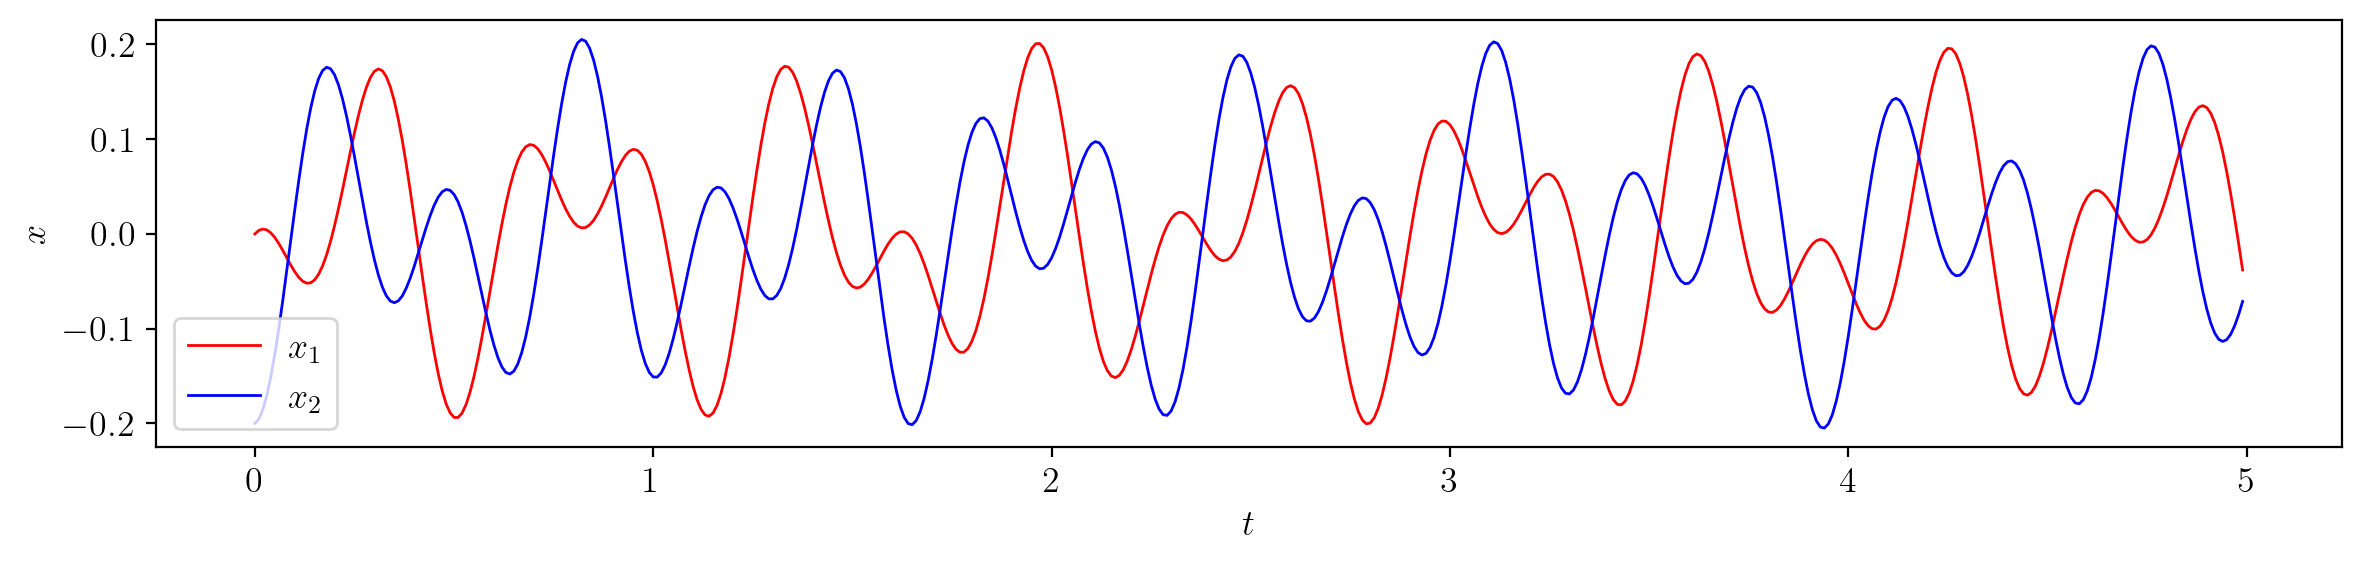

In [382]:
t = np.arange(0, 5, 0.01)
k = (100,120,150)
m = (1.0, 1.0)
xi = (0.0, -0.2)
vi = (0.5, 0.2)
(x1_data, x2_data, v1_data, v2_data) = Model(t, k, m, xi, vi)

plotData(t, x1_data, x2_data)

## Mean Square Error
define the mean square error (MSE) to be
$$
E_{\rm MSE}\left(\vec{k}\right) = \frac{1}{N}\sum_{i=1}^{2}\sum_{j=0}^{N-1}\left(x_{i,j}-x_{\rm theory,j}\left(\vec{k}\right)\right)^2,
$$
where the experimental position data points are given by
$$
x_{i,j},\quad j=0,1,\ldots, N-1,
$$
where $i=1,2$ denote the two masses position, and $\vec{k}=\left(k_1,k_2,k_3\right)$ denote the spring constant.

Define the probability to be
$$
P\left(\vec{k}\right) = \exp\left(-E_{\rm MSE}\left(\vec{k}\right)\right)
$$

In [488]:
def MSE(t, k, x1_data, x2_data, m, xi, vi):
    N = len(t)
    x1_theo, x2_theo, v1_theo ,v2_theo = Model(t, k, m, xi, vi)
    MSE1 = np.sum((x1_data - x1_theo)**2) / N
    MSE2 = np.sum((x2_data - x2_theo)**2) / N
    return MSE1+MSE2

def P_MSE(t, k, x1_data, x2_data, m, xi, vi):
    N = len(t)
    x1_theo, x2_theo, v1_theo ,v2_theo = Model(t, k, m, xi, vi)
    MSE1 = np.sum((x1_data - x1_theo)**2) / N
    MSE2 = np.sum((x2_data - x2_theo)**2) / N
    P = np.exp(-(MSE1+MSE2))
    return P**5000
#     return np.exp(5000*(P-1))

# uncertainty (物理意義還要確定，誠實講清楚)

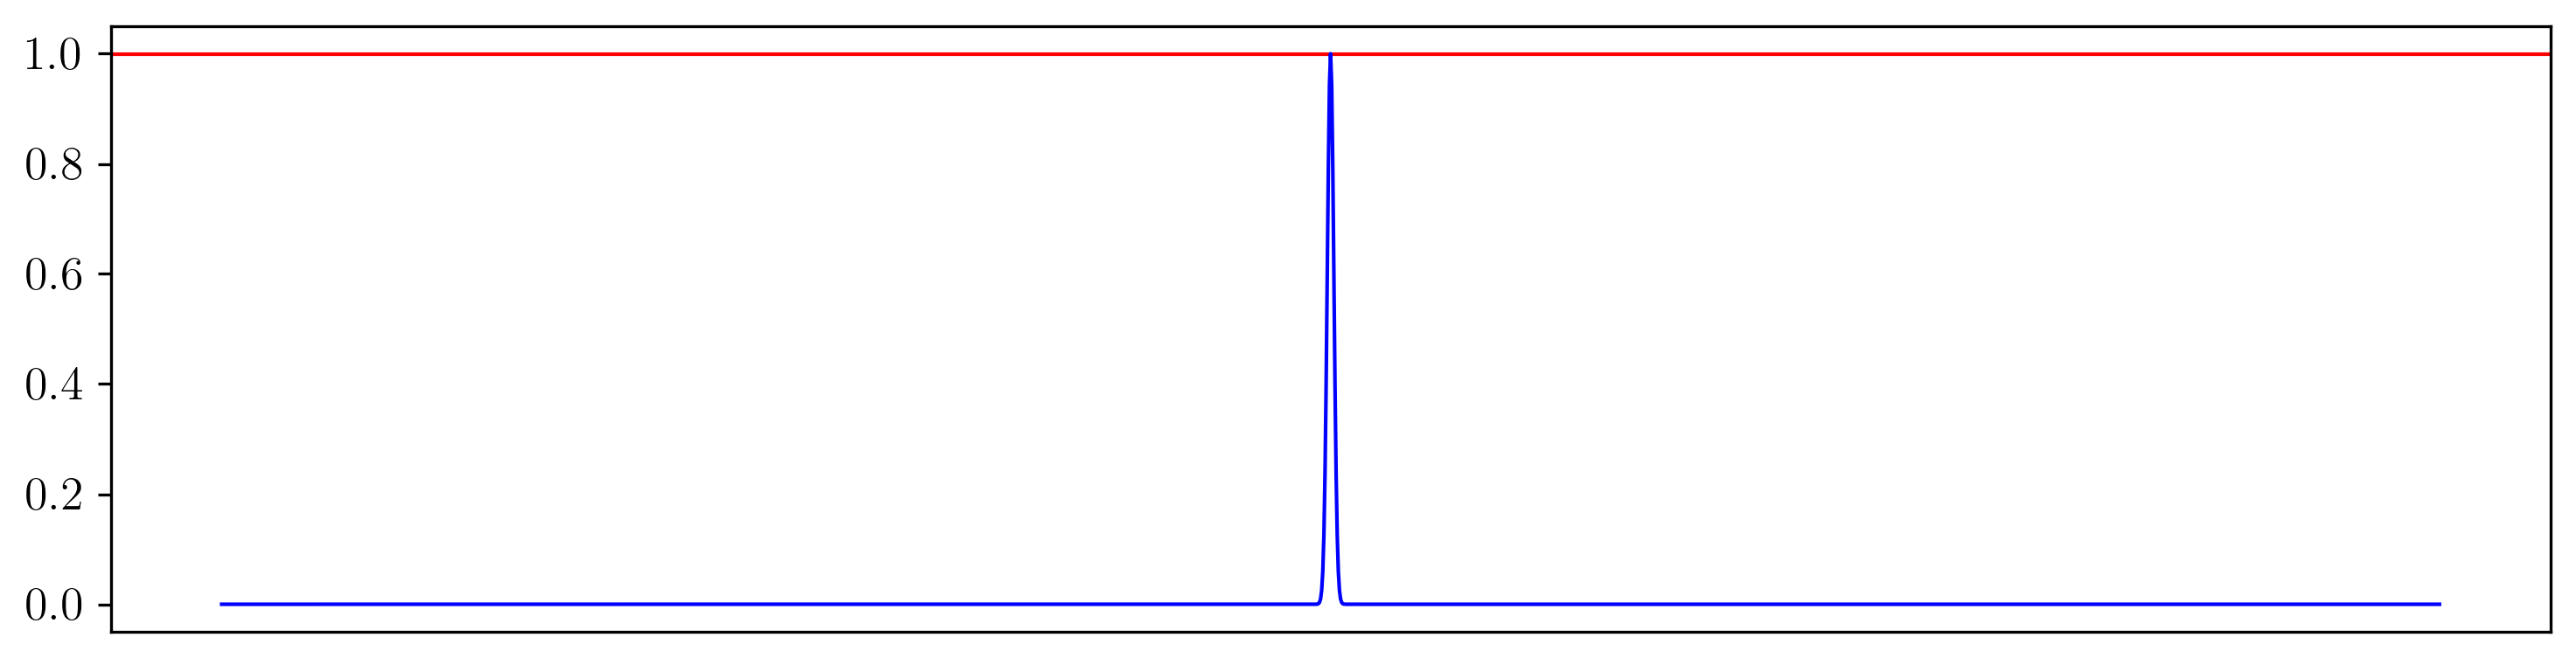

In [489]:
plt.figure(figsize=(12,3))

L = np.linspace(0,1, 1000)

k1 = np.concatenate([L*k[0], k[0]*(1+L[1:])])
k2 = np.concatenate([L*k[1], k[1]*(1+L[1:])])
k3 = np.concatenate([L*k[2], k[2]*(1+L[1:])])

Prob = np.zeros(len(k1))
for i in range(len(k1)):
    Prob[i] = P_MSE(t, (k1[i], k2[i], k3[i]), x1_data, x2_data, m, xi, vi)

plt.axhline(1,color="red")
plt.plot(Prob, color="blue")
plt.xticks([])
plt.show()

In [555]:
paras = 100 + 10*(2*random(3)-1)

delta = 10.2
accN = 0
acc_rate = 0

print(paras)
for i in range(10000):
    paras_ = paras + delta * (2*random(3)-1)
    if any(paras_<0): continue
    p  = P_Chi(t, paras, x1_data, x2_data, m, xi, vi)
    p_ = P_Chi(t, paras_, x1_data, x2_data, m, xi, vi)
    if(p_ >= p or random() < p_/p): 
        paras = paras_
        accN += 1
    acc_rate = accN/(i+1)
print(r"acceptance rate : %.5f"%acc_rate)

N = 100000
Paras = np.zeros([N, 3])
accN = 0
acc_rate = 0

print(paras)
for i in range(N):
    paras_ = paras + delta * (2*random(3)-1)
    if any(paras_<0): continue
    
    p  = P_Chi(t, paras, x1_data, x2_data, m, xi, vi)
    p_ = P_Chi(t, paras_, x1_data, x2_data, m, xi, vi)
    if(p_ >= p or random() < p_/p): 
        paras = paras_
        accN += 1
    acc_rate = accN/(i+1)
    Paras[i] = paras
print(r"acceptance rate : %.5f"%acc_rate)

[99.76332157 97.40597105 94.11570182]
acceptance rate : 0.23050
[ 74.8798123   56.15932817 298.55792399]
acceptance rate : 0.21940


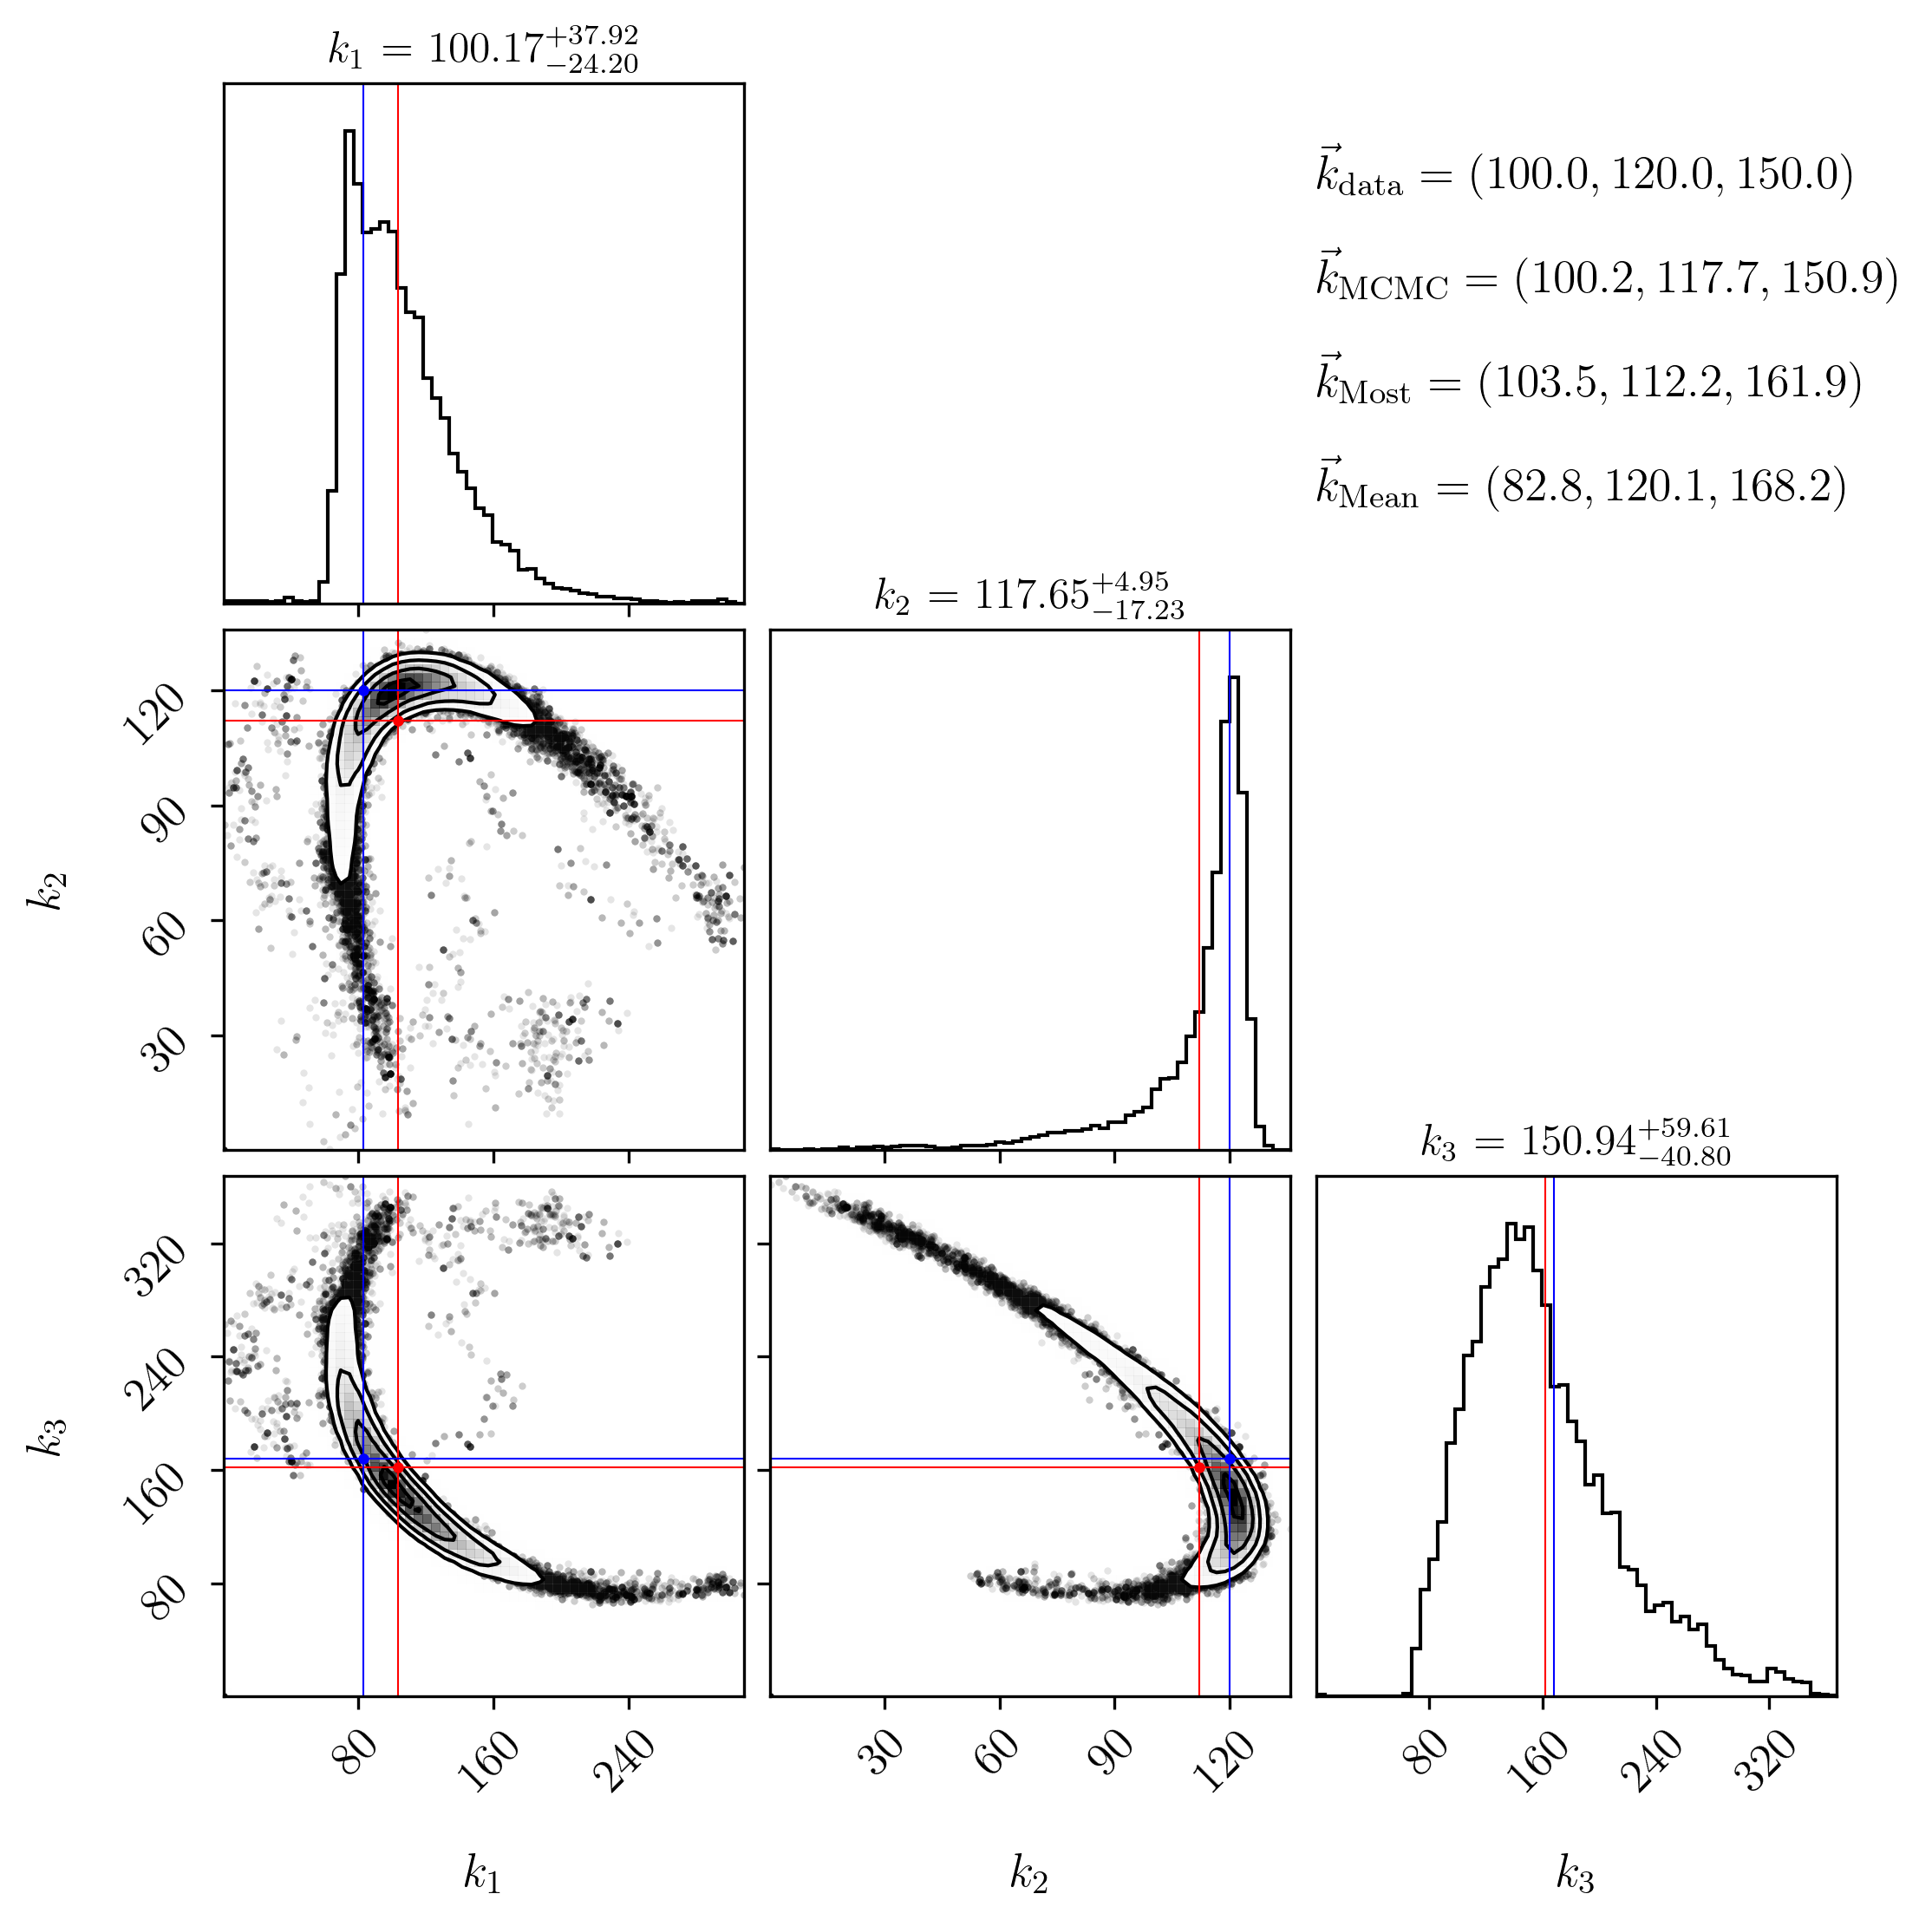

In [556]:
fig = corner.corner(
    Paras, 
    labels=["$k_1$", "$k_2$", "$k_3$"],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    dpi=100,
    smooth=1,
    bins=60
)
corner.overplot_lines(fig, hist_result["mean"], color="red", linewidth=0.5)
corner.overplot_points(fig, hist_result["mean"][None], marker="o", color="red", markersize=2)
corner.overplot_lines(fig, hist_result["max"], color="blue", linewidth=0.5)
corner.overplot_points(fig, hist_result["max"][None], marker="o", color="blue", markersize=2)
hist_result["quantile"] = [corner.quantile(Paras[:,i], [0.16, 0.5, 0.84])[1] for i in [0,1,2]]

n = Paras[0,:].size
fig.axes[n-1].text(0.0,0.8,r"$\vec{k}_{\rm data} =(%.1f,%.1f,%.1f)$"%tuple(np.array(k)))
fig.axes[n-1].text(0.0,0.6,r"$\vec{k}_{\rm MCMC} =(%.1f,%.1f,%.1f)$"%tuple(hist_result["quantile"]))
fig.axes[n-1].text(0.0,0.4,r"$\vec{k}_{\rm Most} =(%.1f,%.1f,%.1f)$"%tuple(hist_result["mean"]))
fig.axes[n-1].text(0.0,0.2,r"$\vec{k}_{\rm Mean} =(%.1f,%.1f,%.1f)$"%tuple(hist_result["max"]))
fig.axes[n-1].set_xlim(0,1)
fig.axes[n-1].set_ylim(0,1)

plt.show()

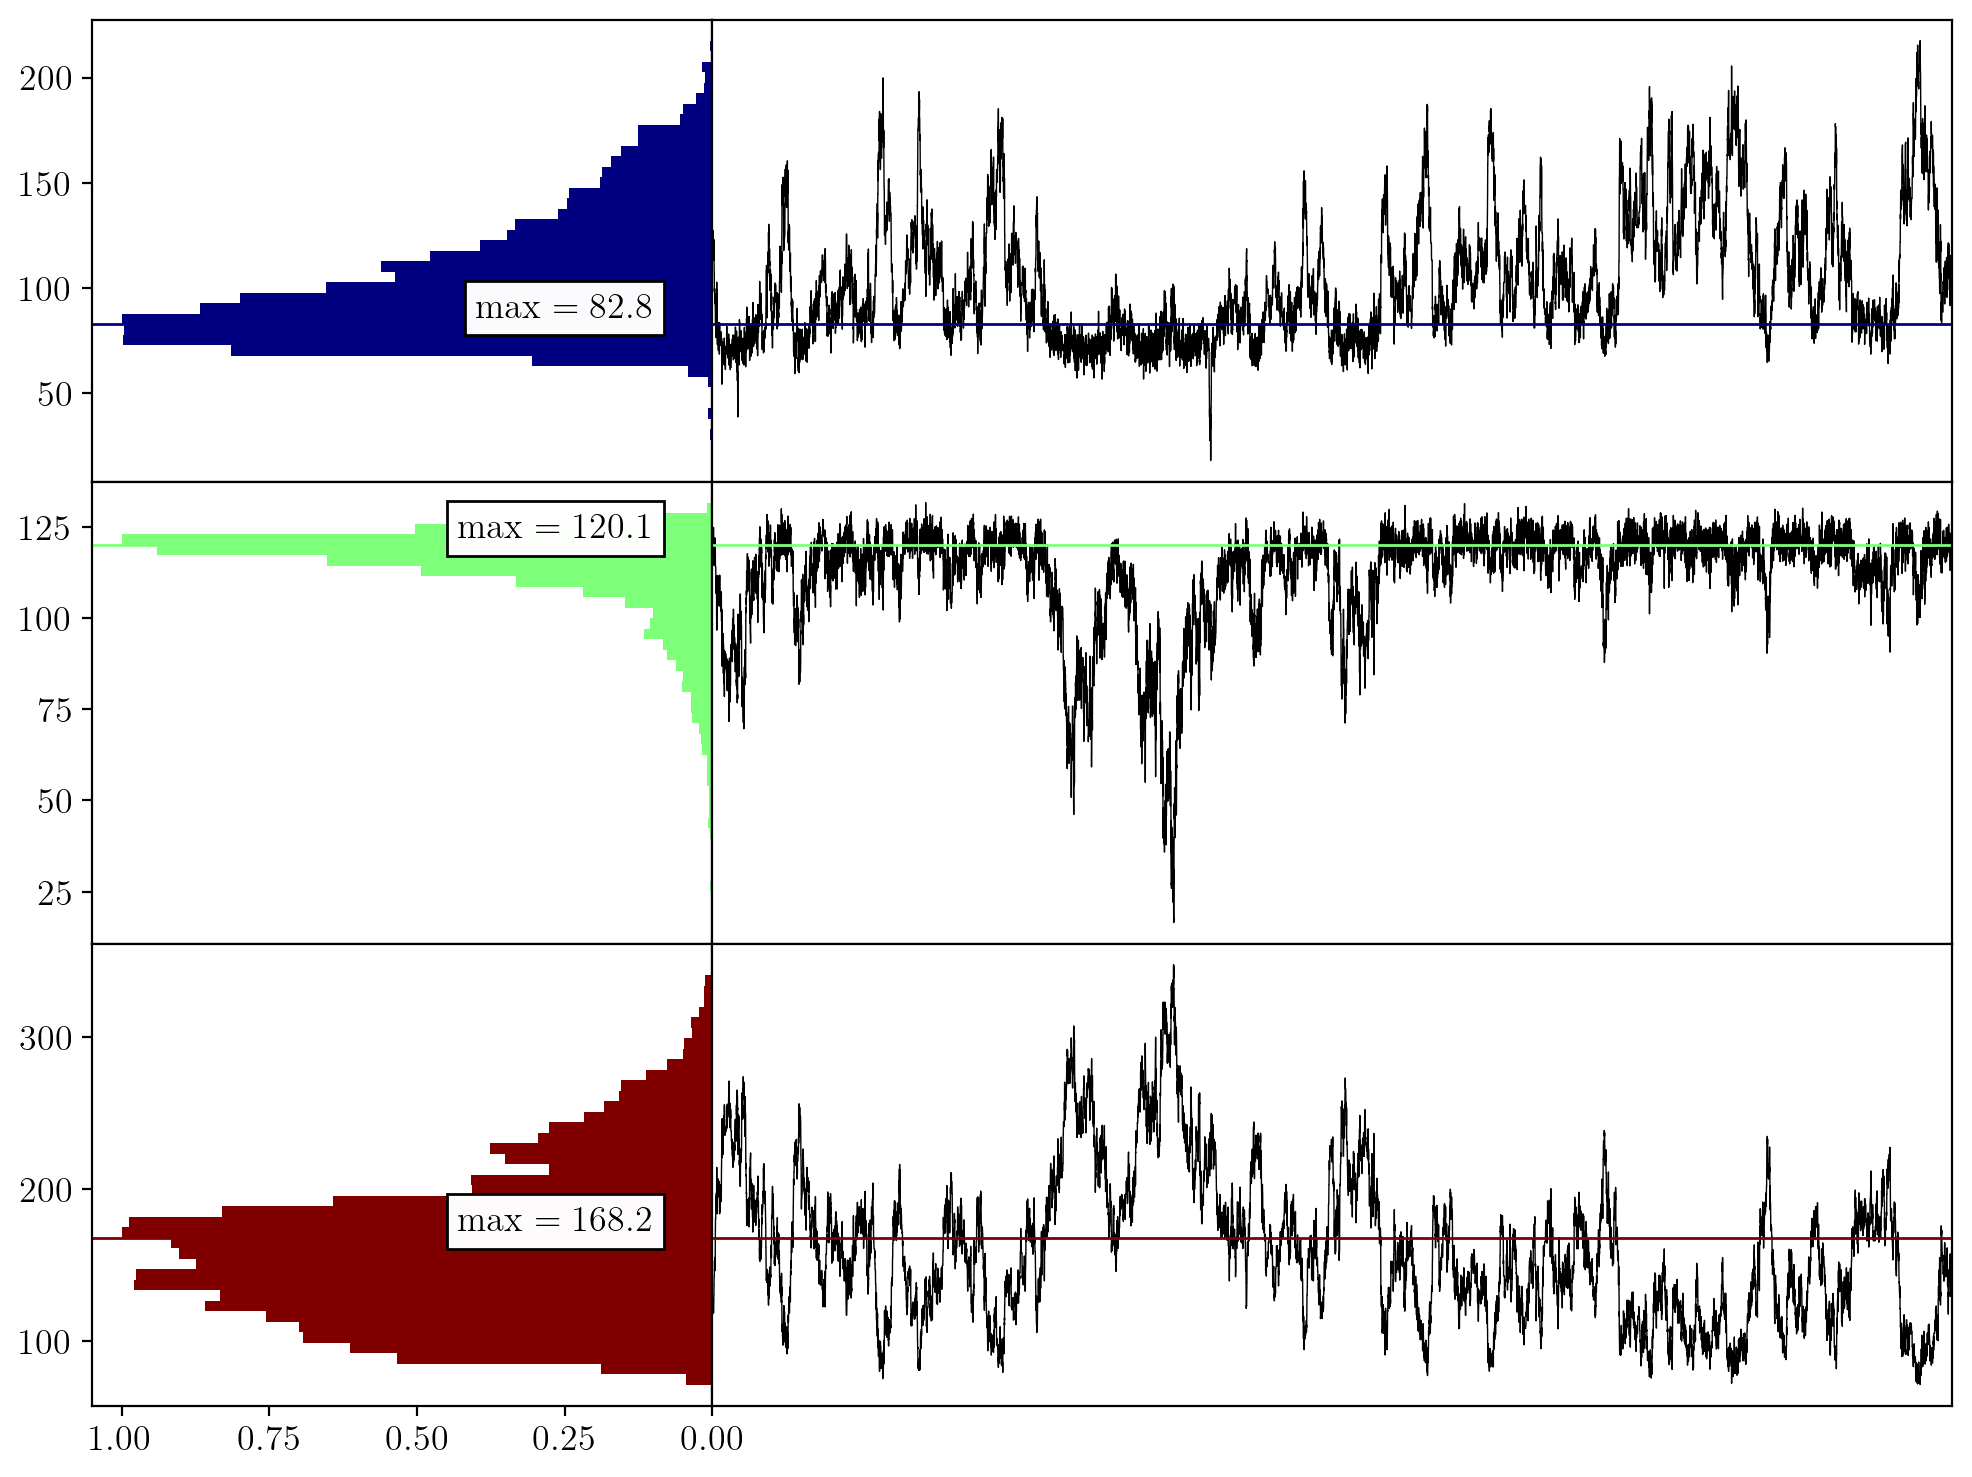

{'max': array([ 82.7567868 , 120.1314665 , 168.16034272]), 'mean': array([103.46341425, 112.20360126, 161.91665002])}


In [506]:
hist_result = histMCMC(Paras, bins=40)
print(hist_result)

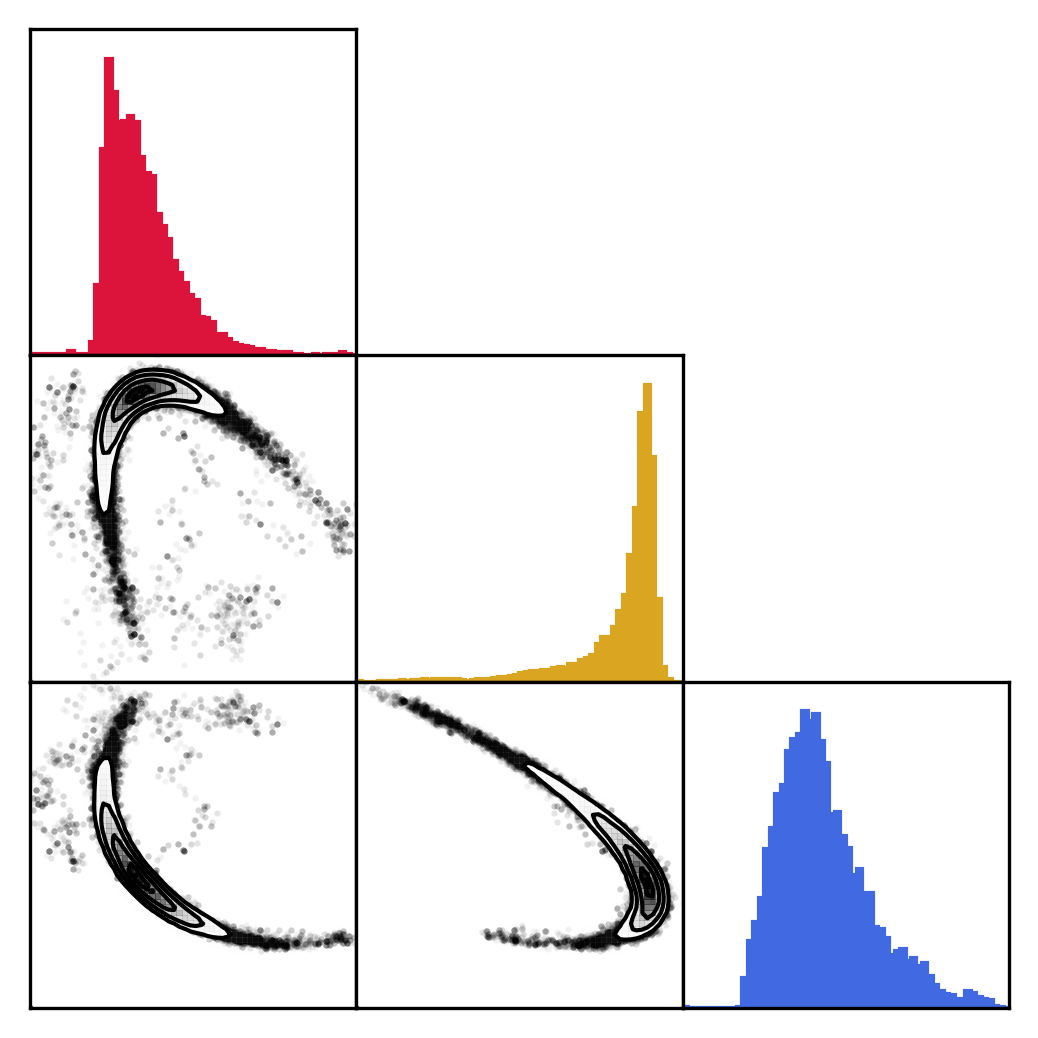

In [628]:
fig = corner.corner(
    Paras, 
    smooth=1,
    bins=60,
)
rgb = lambda r,g,b: (r/255, g/255, b/255, 1.0)
fig.set_size_inches(4, 4)
for ax in fig.axes:
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.axes[0].get_children()[0].set_color("crimson")
fig.axes[0].get_children()[0].set_fill("crimson")

fig.axes[4].get_children()[0].set_color("goldenrod")
fig.axes[4].get_children()[0].set_fill("goldenrod")

fig.axes[8].get_children()[0].set_color("royalblue")
fig.axes[8].get_children()[0].set_fill("royalblue")


markersize = 1.5
# fig.axes[3].get_children()[1].set_color( rgb(206, 108, 66))
# fig.axes[3].get_lines()[0].set_color( rgb(206, 108, 66) )
fig.axes[3].get_lines()[0].set_alpha(0.05)
fig.axes[3].get_lines()[0].set_markersize(markersize)

# fig.axes[6].get_children()[1].set_color( rgb(138, 77, 142))
# fig.axes[6].get_lines()[0].set_color(rgb(138, 77, 142))
fig.axes[6].get_lines()[0].set_alpha(0.05)
fig.axes[6].get_lines()[0].set_markersize(markersize)

# fig.axes[7].get_children()[1].set_color(rgb(142, 136, 141))
# fig.axes[7].get_lines()[0].set_color(rgb(142, 136, 141))
fig.axes[7].get_lines()[0].set_alpha(0.05)
fig.axes[7].get_lines()[0].set_markersize(markersize)

fig.subplots_adjust(hspace=0, wspace=0)
plt.show()

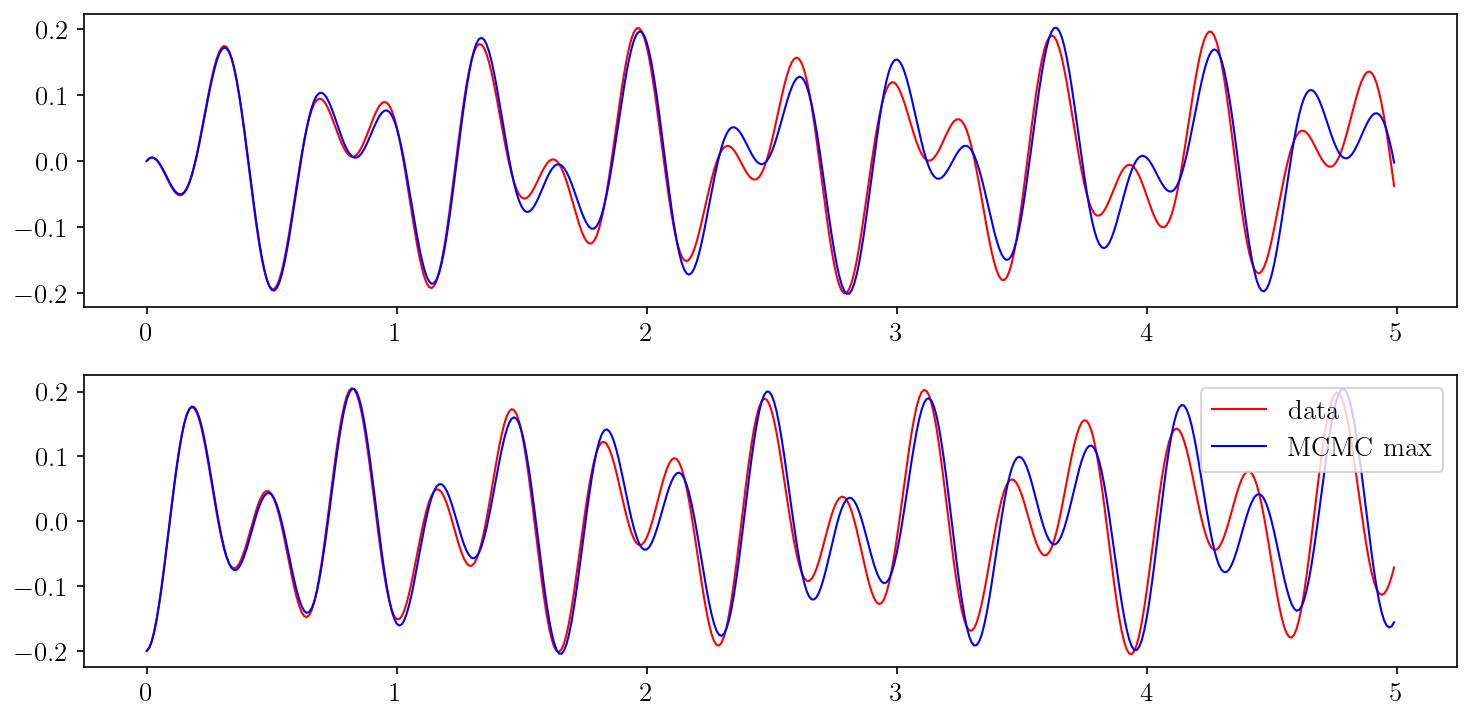

In [484]:
(x1_data_max, x2_data_max, v1_data, v2_data) = Model(t, (102, 117, 150), m, xi, vi)
# (x1_data_mean, x2_data_mean, v1_data, v2_data) = Model(t, hist_result["mean"], m, xi, vi)

fig,axs = plt.subplots(2,1,figsize=(10,5),dpi=150)
axs[0].plot(t,x1_data, color="red", label=r"data")
axs[1].plot(t,x2_data, color="red", label=r"data")
axs[0].plot(t,x1_data_max, color="blue", label=r"MCMC max")
axs[1].plot(t,x2_data_max, color="blue", label=r"MCMC max")
# axs[0].plot(t,x1_data_mean, color="lightcoral", label=r"MCMC mean")
# axs[1].plot(t,x2_data_mean, color="lightblue", label=r"MCMC mean")
plt.legend()
plt.tight_layout()
plt.show()